# Bir sayının 5 olup olmadığını anlamaya çalışan algoritma

In [3]:
#Model
import numpy as np
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
X,y=mnist['data'],mnist['target']
X_train=X[:60000]
x_test= X[60000:]
y_train=y[:60000]
y_test= y[60000:]
#training data üzerinden shuffle_index
np.random.seed(1983)
shuffle_index=np.random.permutation(60000)
X_train=X_train[shuffle_index]
y_train=y_train[shuffle_index]
#5 mi değil mi deneyi
y_train_5=(y_train == 5)
y_test_5 =(y_test == 5)
#Stokastik Gradyan Deseni
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=1983)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=1983,
       shuffle=True, tol=None, verbose=0, warm_start=False)

# Accuracy

In [4]:
#model hazır modelin gücüne training data üzerinden bakalım, henüz test sette deneme yapmadık
#acc
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")


array([ 0.9551 ,  0.96455,  0.9631 ])

# Confusion Matrix, Precision, Recall

In [5]:
#conf matrix
from sklearn.model_selection import  cross_val_predict
#5 olup olmadıığı
y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53504,  1075],
       [ 1270,  4151]], dtype=int64)

In [6]:
#prec
from sklearn.metrics import precision_score
precision_score(y_train_5,y_train_pred)

0.79429774205893611

In [7]:
#recall
from sklearn.metrics import recall_score
recall_score(y_train_5,y_train_pred)

0.76572588083379445

# Precision Recall (PR) Eğrisi

Bu eğriyi oluşturabilmek için karar fonksiyonunun oluşturduğu skor değerler hesaplanmalıdır. Bu skor değerler zaten daha sonra eşik değerden büyük ise true aksi halde false değer alarak etiketlemeyi yapar. 

In [9]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

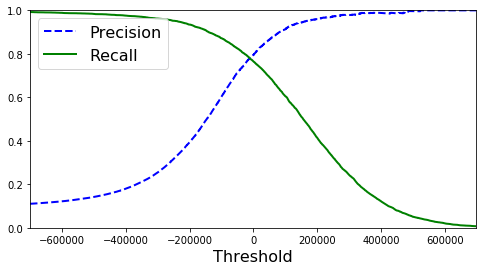

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
#save_fig("precision_recall_vs_threshold_plot")
plt.show()

# ROC Eğrisi

In [16]:
# Roc eğrisinin çizilebilmesi için FPR değeri hesaplanmalı
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

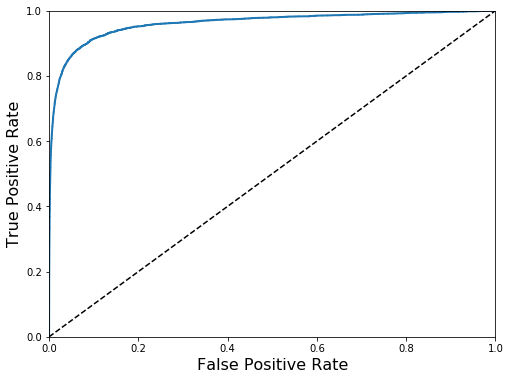

In [18]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
#save_fig("roc_curve_plot")
plt.show()

Yukarıdaki eğride mavi çizgi sol üst köşeye ne kadar yaklaşırsa o kadar iyidir.

# Hangi durumda PR hangi durumda ROC eğrisi?

Pozitif etiket az ise PR, tersi ise ROC eğrisi çizdirilerek performans kontrolü yapılmalı.

# ROC Auc nedir?

In [19]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.96115554524571833

Roc eğrisinde mavi çizgi altında kalan alandır. Bu alan kusursuz bir tahmin algortitmasında 1'dir. Eğri yerine parametreye bakmak istendiğinde kullanılır.

# Precision Recall varken neden PR ve ROC eğrisi?

Algoritmada P/R tradeoff'u durumunda ayarlama yapmak için ya da algoritmanın daha fazla iyileştirilip iyileştirilemeyeceğine dair fikir yürütmek için bu grafiklere bakılır.

Bir de farklı algoritmaların performansı da görsel olarak mukayese edilebilir.

# Random Forest Algoritması ile Deneme

In [21]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

#Random forest algoritmasında skor hesabı yoktur bunun yerine
#predict probability'i skor olarak alabilirsiniz 

In [22]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

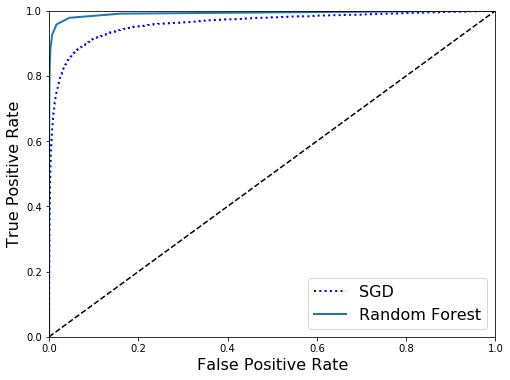

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

Random forest daha tepede olduğundan daha güçlü

In [25]:
roc_auc_score(y_train_5, y_scores_forest)

0.99185820280264458

In [26]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9843853089949417

In [27]:
recall_score(y_train_5, y_train_pred_forest)

0.82567791920309908